In [1]:
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!pip install faiss-cpu


'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2'
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import faiss


In [2]:
# Workaround for Google Colab's default args
sys.argv = ['']

# Define your argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--debug", action='store_true', help="Debug mode")
args = ap.parse_args()

# Example of using the parsed arguments
if args.debug:
    print("Debug mode is ON")

# Set a manual seed
torch.manual_seed(0)

In [3]:
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.995
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 5

### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
#train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)


debug = args.debug
if debug:
    train_dataset.data = train_dataset.data[:1000]
    train_dataset.targets = train_dataset.targets[:1000]

    torch.set_num_threads(4)
val_dataset = deepcopy(train_dataset)


Files already downloaded and verified


In [4]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set

indexes_val = np.array(indexes[train_size:])
val_dataset.targets = np.array(val_dataset.targets)[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

# Define training set
indexes_train = np.array(indexes[train_size:])
train_dataset.targets = np.array(train_dataset.targets)[indexes_val]
train_dataset.data = train_dataset.data[indexes_val]


# Split training data into labelled and unlabelled
unlabelled_size = int(unlabelled_size * len(train_dataset))
indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)
unlabbelled_dataset.targets = unlabbelled_dataset.targets[indexes_train[:unlabelled_size]]
unlabbelled_dataset.data = unlabbelled_dataset.data[indexes_train[:unlabelled_size]]
train_dataset.targets = train_dataset.targets[indexes_train[unlabelled_size:]]
train_dataset.data = train_dataset.data[indexes_train[unlabelled_size:]]
unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline


def transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, indexes):
    # Ensure indexes are a numpy array
    indexes = np.isin(np.arange(len(unlabelled_dataset.targets)), indexes)

    # Add selected samples to train dataset
    train_dataset.targets = np.concatenate([train_dataset.targets, unlabelled_dataset.targets[indexes]])
    train_dataset.data = np.concatenate([train_dataset.data, unlabelled_dataset.data[indexes]])

    # Remove selected samples from unlabelled dataset
    mask = np.ones(len(unlabelled_dataset.targets), dtype=bool)
    mask[indexes] = False
    unlabelled_dataset.targets = unlabelled_dataset.targets[mask]
    unlabelled_dataset.data = unlabelled_dataset.data[mask]

    return train_dataset, unlabelled_dataset


def transfer_unlabelled_to_labeled2(unlabbelled_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unlabbelled_dataset.targets))])

    print(type(train_dataset.targets), train_dataset.targets.dtype)
    print(type(unlabbelled_dataset.targets), unlabbelled_dataset.targets.dtype)

    train_dataset.targets = torch.cat([train_dataset.targets, unlabbelled_dataset.targets[indexes]])
    train_dataset.data = torch.cat([train_dataset.data, unlabbelled_dataset.data[indexes]])
    unlabbelled_dataset.targets = unlabbelled_dataset.targets[~indexes]
    unlabbelled_dataset.data = unlabbelled_dataset.data[~indexes]

    return train_dataset, unlabbelled_dataset

def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
train_size

45000

In [6]:
unlabelled_size

4975

In [7]:
val_size

5000

In [8]:
start_train_dataset

Dataset CIFAR10
    Number of datapoints: 25
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies


def label_iteration(model, train_dataset, unlabelled_dataset, device, top_frac=0.01, method="uncertainty"):
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Collect predictions
    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc=f"Evaluating {method}"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Get probabilities
            predictions.extend(probs.cpu().numpy())

    predictions = torch.tensor(predictions)

    if method == "uncertainty":
        #entropy: -sum(p * log(p))
        entropy = -torch.sum(predictions * torch.log(predictions + 1e-10), dim=1)
        top_indices = torch.argsort(entropy, descending=True)[:int(top_frac * len(predictions))]
    elif method == "margin":
        #margin: difference between top two probabilities
        sorted_probs, _ = torch.sort(predictions, descending=True, dim=1)
        margin = sorted_probs[:, 0] - sorted_probs[:, 1]
        top_indices = torch.argsort(margin)[:int(top_frac * len(predictions))]  # Smallest margins
    else:
        raise ValueError("Invalid method. Choose between 'uncertainty' and 'margin'.")

    print(f"Adding {len(top_indices)} images to training set using {method}-based selection")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)

    return train_dataset, unlabelled_dataset


In [6]:
def visualize_clusters(features, cluster_labels, method="tsne", num_clusters=10):
    reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    reduced_features = reducer.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=cluster_labels,
        cmap='tab20',
        s=10,
        alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.title(f"Cluster Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [7]:
import matplotlib.pyplot as plt

def visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=10):
    if method == "tsne":
        valid_perplexity = min(30, len(features) - 1)
        reducer = TSNE(n_components=2, random_state=42, perplexity=valid_perplexity, n_iter=300)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")

    reduced_features = reducer.fit_transform(features)

    # Plot clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=cluster_labels,
        cmap='tab20',
        s=10,
        alpha=0.7
    )
    selected_points = reduced_features[selected_indices]
    plt.scatter(
        selected_points[:, 0],
        selected_points[:, 1],
        color='red',
        marker='x',
        s=50,
        label='Selected Points'
    )

    plt.colorbar(scatter, label="Cluster ID")
    plt.title(f"Cluster Visualization with Active Learning ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

In [27]:
  
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

def label_iteration_with_dbscan(model, train_dataset, unlabelled_dataset, device, budget, eps=0.2, min_samples=5):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    if eps is None:
        distances = pairwise_distances(features)
        eps = np.median(distances)
        print(f"Automatically chosen eps: {eps:.2f}")
        plt.hist(distances.ravel(), bins=50)
        plt.title("Pairwise Distance Distribution")
        plt.xlabel("Distance")
        plt.ylabel("Frequency")
        plt.show()

    # Apply DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    cluster_labels = clustering.fit_predict(features)
    

     # Debugging: Cluster distribution
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster distribution: {dict(zip(unique, counts))}")

    # Handle noise points (label -1 in DBSCAN)
    if -1 in cluster_labels:
        print(f"Found {sum(cluster_labels == -1)} noise points. Excluding them from selection.")
        valid_indices = np.where(cluster_labels != -1)[0]
        cluster_labels = cluster_labels[valid_indices]
        features = features[valid_indices]
    else:
        valid_indices = np.arange(len(cluster_labels))

   

    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, neighbors=min_samples)

    # Collect points from clusters
    cluster_indices = {i: [] for i in np.unique(cluster_labels)}
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        print("-----hello-----")
        if indices:
            print("-----hi-----")
            cluster_features = features[indices]
            cluster_densities = densities[indices]
            top_5_indices = np.argsort(cluster_densities)[-10:]
            selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f"num_clusters : {num_clusters}")
    visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=num_clusters)
    if num_clusters>1:
        dbi = davies_bouldin_score(features, cluster_labels)
        print(f"Davies-Bouldin Index: {dbi}")
    else: 
        print("Davies-Bouldin Index: Only one cluster")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")
    return train_dataset, unlabelled_dataset


In [9]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import pairwise_distances

def label_iteration_with_hdbscan(model, train_dataset, unlabelled_dataset, device, budget, min_cluster_size=20, min_samples=10):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Extract features
    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    # Perform HDBSCAN clustering
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
    cluster_labels = clusterer.fit_predict(features)

    # Print cluster information
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster distribution: {dict(zip(unique_clusters, counts))}")

    # Compute densities for each sample
    cluster_indices = {i: [] for i in range(len(unique_clusters)) if i != -1}
    for idx, label in enumerate(cluster_labels):
        if label != -1:  # Ignore noise points (-1)
            cluster_indices[label].append(idx)

    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, neighbors=min_samples)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        cluster_features = features[indices]
        cluster_densities = densities[indices]
        top_5_indices = np.argsort(cluster_densities)[-10:]
        selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    # Transfer selected samples to labeled dataset
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")

    return train_dataset, unlabelled_dataset

In [20]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

def label_iteration_with_Herar(model, train_dataset, unlabelled_dataset, device, budget, num_neighbors=20, num_clusters=10):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    num_clusters = min(len(unlabelled_dataset), num_clusters)

    #kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    #cluster_labels = kmeans.fit_predict(features)
    #visualize_clusters(features, cluster_labels, method="tsne", num_clusters=10)

    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_labels = clustering.fit_predict(features)
    dbi = davies_bouldin_score(features, cluster_labels)
    print(f"Davies-Bouldin Index: {dbi}")
    
    
    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, num_neighbors)

    cluster_indices = {i: [] for i in range(num_clusters)}
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        if indices:
            cluster_features = features[indices]
            cluster_densities = densities[indices]
            top_5_indices = np.argsort(cluster_densities)[-10:]
            selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=num_clusters)
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")
    return train_dataset, unlabelled_dataset

In [21]:
from sklearn.metrics import davies_bouldin_score
def label_iteration_with_clustering(model, train_dataset, unlabelled_dataset, device, budget, num_neighbors=20, num_clusters=10):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    num_clusters = min(len(unlabelled_dataset), num_clusters)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    dbi = davies_bouldin_score(features, cluster_labels)
    print(f"Davies-Bouldin Index: {dbi}")
    #visualize_clusters(features, cluster_labels, method="tsne", num_clusters=10)
    
    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, num_neighbors)

    cluster_indices = {i: [] for i in range(num_clusters)}
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        if indices:
            cluster_features = features[indices]
            cluster_densities = densities[indices]
            top_5_indices = np.argsort(cluster_densities)[-10:]
            selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=num_clusters)
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")
    return train_dataset, unlabelled_dataset


 10%|█         | 10/100 [00:01<00:10,  8.43it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.22it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:09,  7.51it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:08,  7.40it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.52it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.56it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:09<00:03,  7.58it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  7.54it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  7.57it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Epoch 100, Accuracy: 8.68%


Evaluating uncertainty: 100%|██████████| 72/72 [00:01<00:00, 46.69it/s]
C:\Users\kubko\AppData\Local\Temp\ipykernel_24524\4117777955.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predictions = torch.tensor(predictions)


Adding 128 images to training set using uncertainty-based selection


 12%|█▏        | 12/100 [00:02<00:20,  4.33it/s]

Epoch 10, Accuracy: 17.84%


 22%|██▏       | 22/100 [00:03<00:16,  4.67it/s]

Epoch 20, Accuracy: 22.58%


 32%|███▏      | 32/100 [00:05<00:14,  4.65it/s]

Epoch 30, Accuracy: 22.56%


 42%|████▏     | 42/100 [00:07<00:12,  4.59it/s]

Epoch 40, Accuracy: 23.08%


 52%|█████▏    | 52/100 [00:09<00:10,  4.79it/s]

Epoch 50, Accuracy: 22.92%


 62%|██████▏   | 62/100 [00:11<00:07,  4.79it/s]

Epoch 60, Accuracy: 23.16%


 72%|███████▏  | 72/100 [00:12<00:05,  5.00it/s]

Epoch 70, Accuracy: 23.24%


 82%|████████▏ | 82/100 [00:14<00:03,  5.20it/s]

Epoch 80, Accuracy: 23.18%


 92%|█████████▏| 92/100 [00:16<00:01,  5.23it/s]

Epoch 90, Accuracy: 23.30%


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 100, Accuracy: 23.26%


Evaluating uncertainty: 100%|██████████| 70/70 [00:01<00:00, 54.88it/s]


Adding 124 images to training set using uncertainty-based selection


 11%|█         | 11/100 [00:02<00:33,  2.68it/s]

Epoch 10, Accuracy: 27.76%


 21%|██        | 21/100 [00:04<00:28,  2.80it/s]

Epoch 20, Accuracy: 29.78%


 31%|███       | 31/100 [00:07<00:24,  2.87it/s]

Epoch 30, Accuracy: 29.96%


 41%|████      | 41/100 [00:09<00:20,  2.90it/s]

Epoch 40, Accuracy: 30.50%


 51%|█████     | 51/100 [00:11<00:17,  2.87it/s]

Epoch 50, Accuracy: 30.76%


 61%|██████    | 61/100 [00:13<00:13,  2.95it/s]

Epoch 60, Accuracy: 30.66%


 71%|███████   | 71/100 [00:15<00:09,  2.93it/s]

Epoch 70, Accuracy: 30.74%


 81%|████████  | 81/100 [00:17<00:06,  2.85it/s]

Epoch 80, Accuracy: 31.02%


 91%|█████████ | 91/100 [00:20<00:03,  2.98it/s]

Epoch 90, Accuracy: 30.92%


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Epoch 100, Accuracy: 30.98%


Evaluating uncertainty: 100%|██████████| 68/68 [00:01<00:00, 57.05it/s]


Adding 121 images to training set using uncertainty-based selection


 11%|█         | 11/100 [00:02<00:34,  2.57it/s]

Epoch 10, Accuracy: 33.46%


 21%|██        | 21/100 [00:05<00:31,  2.54it/s]

Epoch 20, Accuracy: 34.72%


 31%|███       | 31/100 [00:08<00:26,  2.57it/s]

Epoch 30, Accuracy: 35.78%


 41%|████      | 41/100 [00:10<00:24,  2.42it/s]

Epoch 40, Accuracy: 36.20%


 51%|█████     | 51/100 [00:13<00:19,  2.54it/s]

Epoch 50, Accuracy: 36.48%


 61%|██████    | 61/100 [00:16<00:15,  2.52it/s]

Epoch 60, Accuracy: 36.62%


 71%|███████   | 71/100 [00:19<00:11,  2.52it/s]

Epoch 70, Accuracy: 37.06%


 81%|████████  | 81/100 [00:21<00:07,  2.55it/s]

Epoch 80, Accuracy: 36.54%


 91%|█████████ | 91/100 [00:24<00:03,  2.55it/s]

Epoch 90, Accuracy: 36.72%


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


Epoch 100, Accuracy: 36.62%


Evaluating uncertainty: 100%|██████████| 66/66 [00:01<00:00, 49.74it/s]


Adding 117 images to training set using uncertainty-based selection


 10%|█         | 10/100 [00:03<00:49,  1.83it/s]

Epoch 10, Accuracy: 35.92%


 20%|██        | 20/100 [00:06<00:43,  1.84it/s]

Epoch 20, Accuracy: 37.48%


 30%|███       | 30/100 [00:09<00:38,  1.81it/s]

Epoch 30, Accuracy: 37.82%


 40%|████      | 40/100 [00:13<00:35,  1.68it/s]

Epoch 40, Accuracy: 38.32%


 50%|█████     | 50/100 [00:16<00:27,  1.81it/s]

Epoch 50, Accuracy: 38.16%


 60%|██████    | 60/100 [00:19<00:21,  1.82it/s]

Epoch 60, Accuracy: 38.16%


 70%|███████   | 70/100 [00:23<00:16,  1.82it/s]

Epoch 70, Accuracy: 38.40%


 81%|████████  | 81/100 [00:26<00:08,  2.24it/s]

Epoch 80, Accuracy: 38.46%


 90%|█████████ | 90/100 [00:29<00:05,  1.81it/s]

Epoch 90, Accuracy: 38.54%


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 100, Accuracy: 38.52%
<class 'int'>


 11%|█         | 11/100 [00:03<00:42,  2.11it/s]

Epoch 10, Accuracy: 36.12%


 20%|██        | 20/100 [00:06<00:43,  1.83it/s]

Epoch 20, Accuracy: 41.64%


 30%|███       | 30/100 [00:09<00:38,  1.80it/s]

Epoch 30, Accuracy: 41.38%


 40%|████      | 40/100 [00:13<00:33,  1.77it/s]

Epoch 40, Accuracy: 41.62%


 50%|█████     | 50/100 [00:16<00:29,  1.68it/s]

Epoch 50, Accuracy: 41.16%


 60%|██████    | 60/100 [00:20<00:23,  1.69it/s]

Epoch 60, Accuracy: 41.76%


 70%|███████   | 70/100 [00:23<00:16,  1.83it/s]

Epoch 70, Accuracy: 41.86%


 80%|████████  | 80/100 [00:26<00:11,  1.76it/s]

Epoch 80, Accuracy: 41.96%


 90%|█████████ | 90/100 [00:30<00:06,  1.57it/s]

Epoch 90, Accuracy: 42.10%


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]

Epoch 100, Accuracy: 42.24%


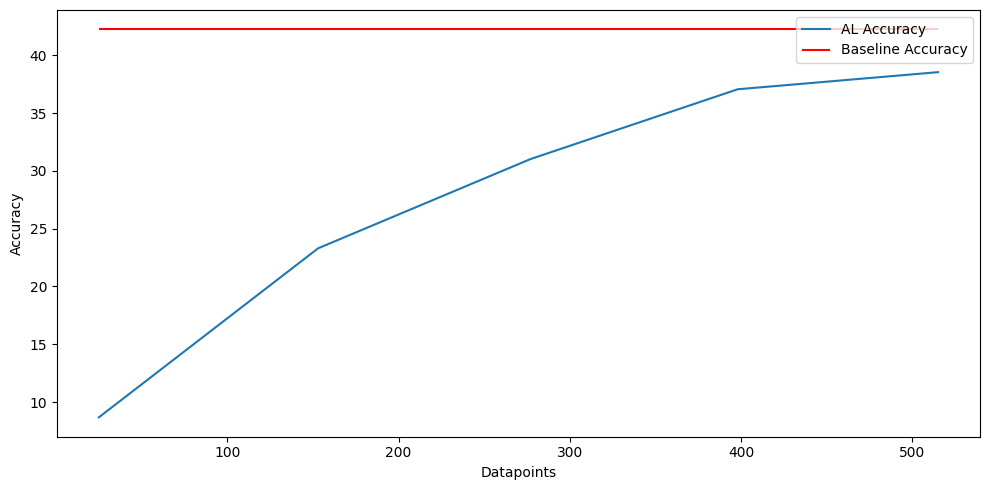

In [23]:
train_dataset.data = start_train_dataset.data
train_dataset.targets = start_train_dataset.targets
model.load_state_dict(model_parameters)

## Run active learning
datapoint_list = []
accuracy_list = []
for i in range(label_iterations):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration(model, train_dataset, unlabbelled_dataset, device, top_frac=0.028)

        
n_datapoints = len(train_dataset) - len(start_train_dataset)
print(type(n_datapoints))
model.load_state_dict(model_parameters)
train_dataset.data = np.concatenate([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
train_dataset.targets = np.concatenate([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)


datapoints = np.array(datapoint_list)
accuracies = np.array(accuracy_list).max(-1)
plt.figure(figsize=(10, 5))
plt.plot(datapoints, accuracies, label='AL Accuracy')
plt.hlines(max(baseline_accuracy), min(datapoints), max(datapoints), label='Baseline Accuracy', color='red')
plt.xlabel('Datapoints')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations, cluster=label_iteration_with_Herar):
    train_dataset.data = start_train_dataset.data
    train_dataset.targets = start_train_dataset.targets
    model.load_state_dict(model_parameters)

    ## Run active learning
    datapoint_list = []
    accuracy_list = []
    for i in range(label_iterations):
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        model.load_state_dict(model_parameters)  # Important to reset the model each time
        accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
        datapoint_list.append(len(train_dataset))
        accuracy_list.append(accuracies)
        if i < label_iterations - 1:
            train_dataset, unlabbelled_dataset = cluster(model, train_dataset, unlabbelled_dataset, device, budget=150)

    n_datapoints = int((len(train_dataset) - len(start_train_dataset))/4)
    print(len(train_dataset) - len(start_train_dataset))
    train_dataset.data = start_train_dataset.data
    train_dataset.targets = start_train_dataset.targets
    baseline_datapoint_list = []
    baseline_accuracy_list = []
    for i in range(label_iterations-1):
        # Train model
        model.load_state_dict(model_parameters)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
        baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
        baseline_datapoint_list.append(len(train_dataset))
        baseline_accuracy_list.append(baseline_accuracy)
        if i < label_iterations - 1:
            # Add baseline accuracy (no active learning)
            print(n_datapoints)
            train_dataset.data = start_train_dataset.data
            train_dataset.targets = start_train_dataset.targets
            # We reuse the initial training set to reduce run to run variance
            train_dataset.data = np.concatenate([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
            train_dataset.targets = np.concatenate([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])
            n_datapoints += n_datapoints

        

    # Plot the accuracy
    datapoints = np.array(datapoint_list)
    accuracies = np.array(accuracy_list).max(-1)
    baseline_datapoint = np.array(baseline_datapoint_list)
    baseline_accuracy = np.array(baseline_accuracy_list).max(-1)
    plt.figure(figsize=(10, 5))
    plt.plot(datapoints, accuracies, label='AL Accuracy')
    plt.plot(baseline_datapoint,baseline_accuracy, label='Baseline Accuracy', color='red')
    plt.xlabel('Datapoints')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    #plt.savefig('figs/accuracy.png')
    plt.show()
    return datapoints,accuracies,baseline_datapoint,baseline_accuracy

 10%|█         | 10/100 [00:01<00:13,  6.91it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:10,  7.93it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.19it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.18it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  8.05it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.91it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  7.84it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  8.09it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.22it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 50/50 [00:00<00:00, 50.14it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 2.3473939096204837


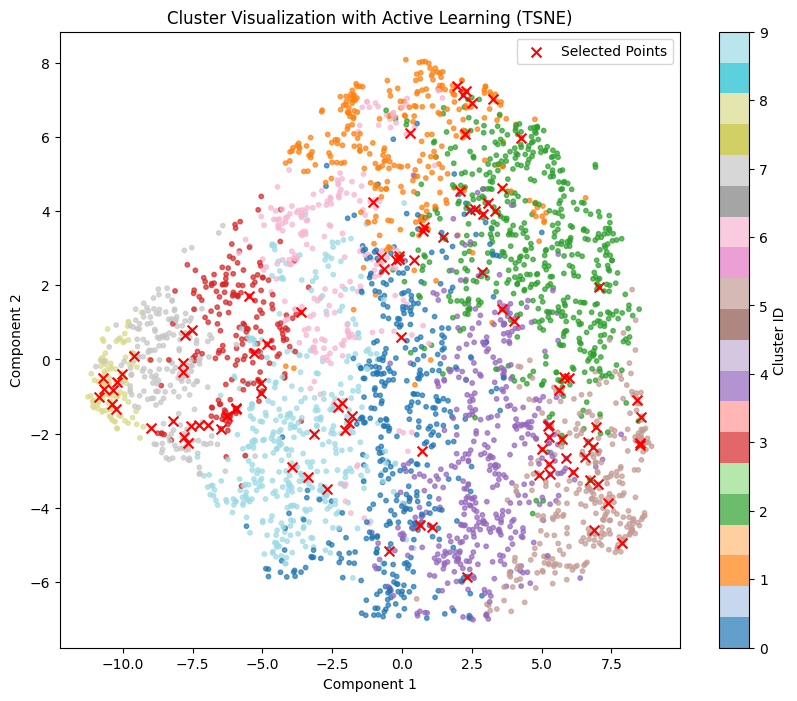

Selected 100 samples for labeling.


 14%|█▍        | 14/100 [00:01<00:10,  7.96it/s]

Epoch 10, Accuracy: 17.36%


 25%|██▌       | 25/100 [00:03<00:09,  8.22it/s]

Epoch 20, Accuracy: 19.42%


 36%|███▌      | 36/100 [00:04<00:07,  8.24it/s]

Epoch 30, Accuracy: 22.32%


 44%|████▍     | 44/100 [00:05<00:07,  7.67it/s]

Epoch 40, Accuracy: 23.14%


 55%|█████▌    | 55/100 [00:07<00:05,  8.15it/s]

Epoch 50, Accuracy: 23.56%


 65%|██████▌   | 65/100 [00:08<00:04,  7.68it/s]

Epoch 60, Accuracy: 23.30%


 76%|███████▌  | 76/100 [00:09<00:02,  8.13it/s]

Epoch 70, Accuracy: 23.02%


 84%|████████▍ | 84/100 [00:11<00:02,  7.68it/s]

Epoch 80, Accuracy: 23.74%


 95%|█████████▌| 95/100 [00:12<00:00,  8.11it/s]

Epoch 90, Accuracy: 23.38%


100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 100, Accuracy: 23.04%


Extracting features: 100%|██████████| 48/48 [00:00<00:00, 53.36it/s]


Davies-Bouldin Index: 2.037479524372948


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


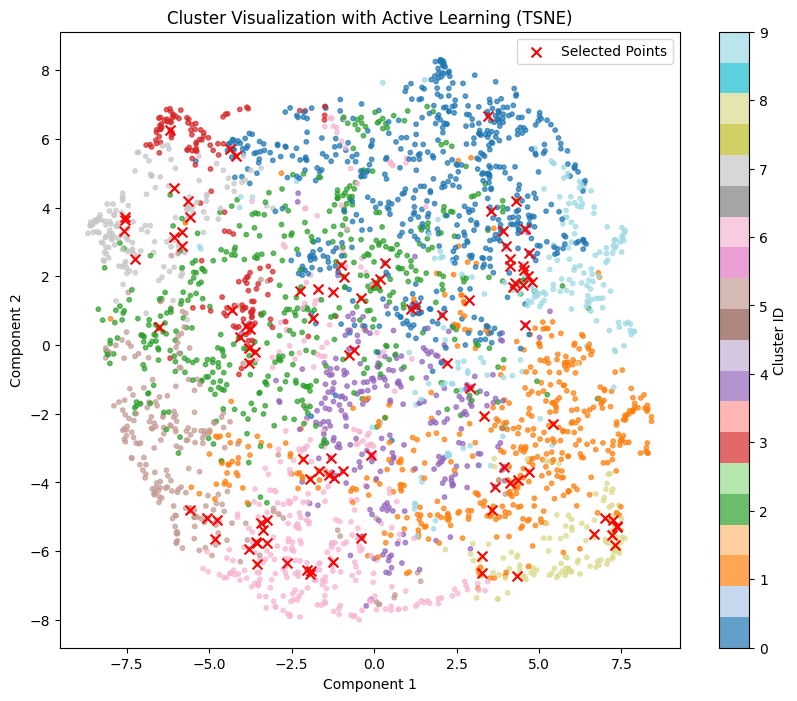

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:23,  3.72it/s]

Epoch 10, Accuracy: 24.66%


 21%|██        | 21/100 [00:03<00:21,  3.67it/s]

Epoch 20, Accuracy: 28.78%


 31%|███       | 31/100 [00:05<00:19,  3.54it/s]

Epoch 30, Accuracy: 30.28%


 41%|████      | 41/100 [00:08<00:18,  3.14it/s]

Epoch 40, Accuracy: 30.56%


 51%|█████     | 51/100 [00:09<00:13,  3.60it/s]

Epoch 50, Accuracy: 30.86%


 61%|██████    | 61/100 [00:11<00:10,  3.70it/s]

Epoch 60, Accuracy: 30.90%


 71%|███████   | 71/100 [00:13<00:07,  3.63it/s]

Epoch 70, Accuracy: 30.80%


 81%|████████  | 81/100 [00:15<00:05,  3.72it/s]

Epoch 80, Accuracy: 30.74%


 91%|█████████ | 91/100 [00:17<00:02,  3.75it/s]

Epoch 90, Accuracy: 31.04%


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Epoch 100, Accuracy: 30.94%


Extracting features: 100%|██████████| 47/47 [00:00<00:00, 59.18it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.8548601054184188


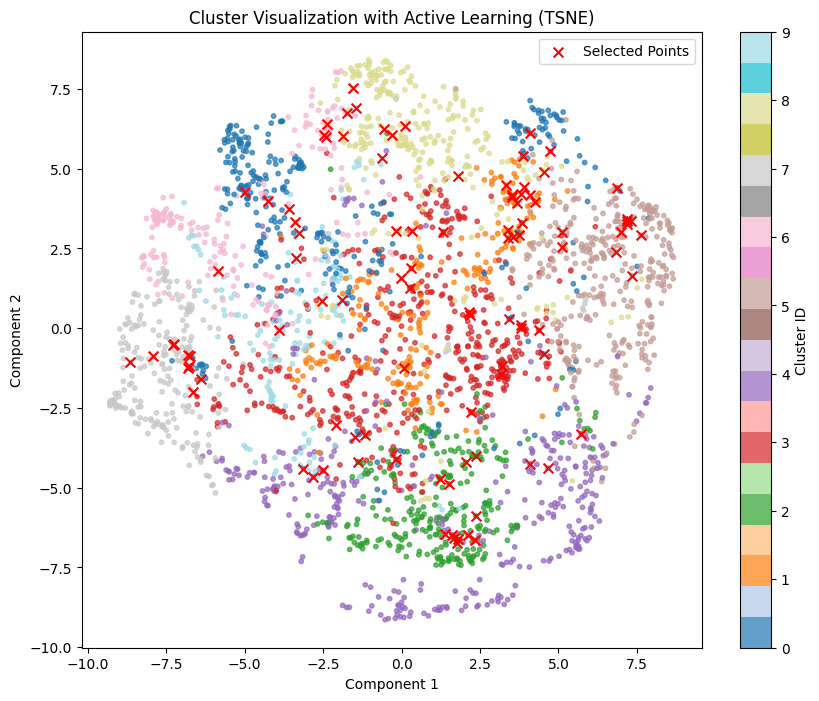

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:31,  2.80it/s]

Epoch 10, Accuracy: 32.34%


 21%|██        | 21/100 [00:05<00:28,  2.74it/s]

Epoch 20, Accuracy: 33.92%


 31%|███       | 31/100 [00:07<00:24,  2.77it/s]

Epoch 30, Accuracy: 34.58%


 41%|████      | 41/100 [00:09<00:20,  2.82it/s]

Epoch 40, Accuracy: 34.42%


 51%|█████     | 51/100 [00:12<00:17,  2.80it/s]

Epoch 50, Accuracy: 34.76%


 61%|██████    | 61/100 [00:14<00:14,  2.76it/s]

Epoch 60, Accuracy: 35.02%


 71%|███████   | 71/100 [00:16<00:10,  2.71it/s]

Epoch 70, Accuracy: 34.94%


 81%|████████  | 81/100 [00:19<00:06,  2.72it/s]

Epoch 80, Accuracy: 34.96%


 91%|█████████ | 91/100 [00:21<00:03,  2.60it/s]

Epoch 90, Accuracy: 34.80%


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Epoch 100, Accuracy: 34.84%


Extracting features: 100%|██████████| 45/45 [00:00<00:00, 57.20it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.9900690936127272


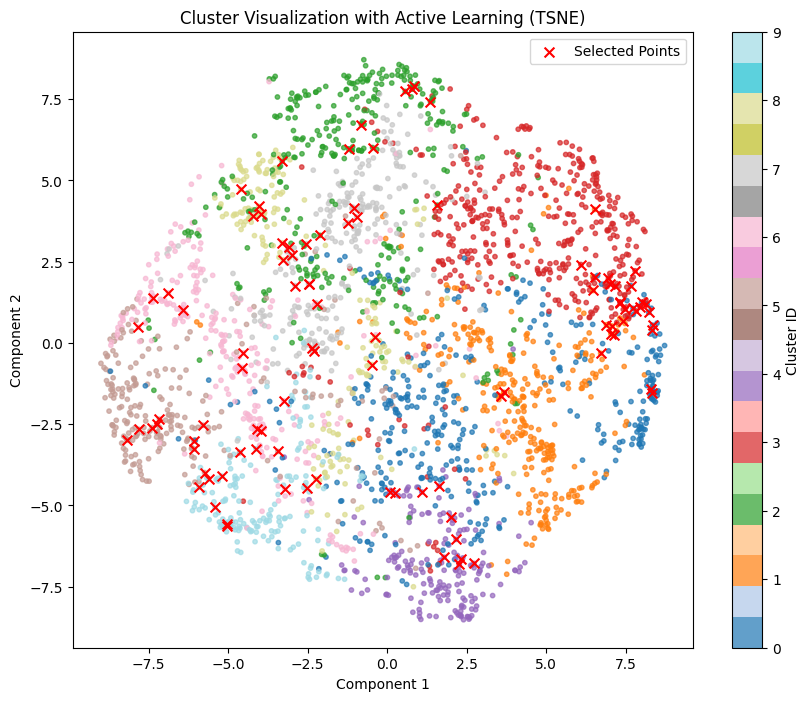

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:03<00:35,  2.54it/s]

Epoch 10, Accuracy: 36.80%


 21%|██        | 21/100 [00:05<00:30,  2.55it/s]

Epoch 20, Accuracy: 38.64%


 31%|███       | 31/100 [00:08<00:26,  2.59it/s]

Epoch 30, Accuracy: 39.18%


 41%|████      | 41/100 [00:11<00:23,  2.50it/s]

Epoch 40, Accuracy: 38.80%


 51%|█████     | 51/100 [00:13<00:19,  2.48it/s]

Epoch 50, Accuracy: 39.46%


 61%|██████    | 61/100 [00:16<00:15,  2.58it/s]

Epoch 60, Accuracy: 39.56%


 71%|███████   | 71/100 [00:19<00:11,  2.50it/s]

Epoch 70, Accuracy: 39.80%


 81%|████████  | 81/100 [00:21<00:07,  2.53it/s]

Epoch 80, Accuracy: 39.96%


 91%|█████████ | 91/100 [00:24<00:03,  2.50it/s]

Epoch 90, Accuracy: 40.30%


100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


Epoch 100, Accuracy: 40.16%
400


 10%|█         | 10/100 [00:01<00:10,  8.92it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.55it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.52it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.36it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  8.10it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.62it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  8.05it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:09<00:02,  8.30it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:10<00:01,  8.31it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 100, Accuracy: 8.68%
100


 16%|█▌        | 16/100 [00:01<00:09,  8.80it/s]

Epoch 10, Accuracy: 15.32%


 24%|██▍       | 24/100 [00:03<00:10,  7.24it/s]

Epoch 20, Accuracy: 18.88%


 34%|███▍      | 34/100 [00:04<00:09,  6.98it/s]

Epoch 30, Accuracy: 21.48%


 44%|████▍     | 44/100 [00:06<00:07,  7.10it/s]

Epoch 40, Accuracy: 22.18%


 54%|█████▍    | 54/100 [00:07<00:06,  7.31it/s]

Epoch 50, Accuracy: 24.44%


 65%|██████▌   | 65/100 [00:08<00:04,  7.89it/s]

Epoch 60, Accuracy: 24.48%


 75%|███████▌  | 75/100 [00:10<00:03,  7.34it/s]

Epoch 70, Accuracy: 24.58%


 86%|████████▌ | 86/100 [00:11<00:01,  7.77it/s]

Epoch 80, Accuracy: 24.44%


 94%|█████████▍| 94/100 [00:12<00:00,  7.45it/s]

Epoch 90, Accuracy: 24.70%


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 100, Accuracy: 24.92%
200


 11%|█         | 11/100 [00:02<00:25,  3.53it/s]

Epoch 10, Accuracy: 25.50%


 21%|██        | 21/100 [00:04<00:24,  3.27it/s]

Epoch 20, Accuracy: 27.80%


 31%|███       | 31/100 [00:06<00:20,  3.39it/s]

Epoch 30, Accuracy: 29.74%


 42%|████▏     | 42/100 [00:08<00:14,  3.92it/s]

Epoch 40, Accuracy: 27.90%


 52%|█████▏    | 52/100 [00:10<00:11,  4.29it/s]

Epoch 50, Accuracy: 28.38%


 62%|██████▏   | 62/100 [00:12<00:08,  4.46it/s]

Epoch 60, Accuracy: 28.84%


 72%|███████▏  | 72/100 [00:14<00:06,  4.41it/s]

Epoch 70, Accuracy: 28.76%


 82%|████████▏ | 82/100 [00:16<00:04,  4.46it/s]

Epoch 80, Accuracy: 28.96%


 91%|█████████ | 91/100 [00:18<00:02,  3.88it/s]

Epoch 90, Accuracy: 28.96%


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Epoch 100, Accuracy: 29.08%
400


 11%|█         | 11/100 [00:02<00:36,  2.44it/s]

Epoch 10, Accuracy: 34.76%


 21%|██        | 21/100 [00:05<00:33,  2.36it/s]

Epoch 20, Accuracy: 37.52%


 31%|███       | 31/100 [00:08<00:32,  2.15it/s]

Epoch 30, Accuracy: 37.80%


 41%|████      | 41/100 [00:11<00:25,  2.35it/s]

Epoch 40, Accuracy: 38.04%


 51%|█████     | 51/100 [00:14<00:20,  2.40it/s]

Epoch 50, Accuracy: 37.84%


 61%|██████    | 61/100 [00:17<00:17,  2.21it/s]

Epoch 60, Accuracy: 37.96%


 71%|███████   | 71/100 [00:20<00:12,  2.40it/s]

Epoch 70, Accuracy: 37.82%


 81%|████████  | 81/100 [00:23<00:08,  2.37it/s]

Epoch 80, Accuracy: 38.00%


 91%|█████████ | 91/100 [00:26<00:03,  2.43it/s]

Epoch 90, Accuracy: 38.12%


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]

Epoch 100, Accuracy: 37.76%
800


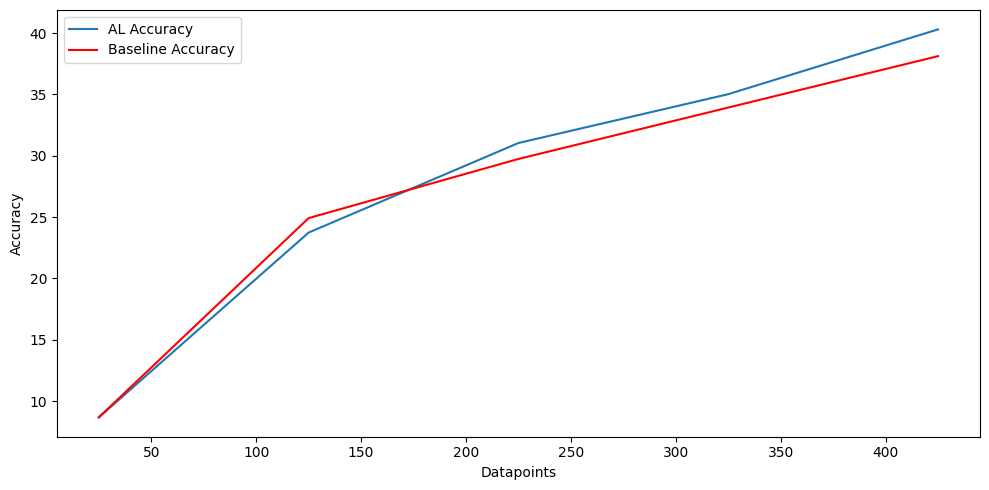

In [29]:
datapoints,accuracies,baseline_datapoint_list,baseline_accuracy_list=run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations,cluster=label_iteration_with_Herar)

 10%|█         | 10/100 [00:01<00:10,  8.92it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.59it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.42it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.13it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.54it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.69it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:09<00:04,  7.34it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  7.66it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.06it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 57/57 [00:00<00:00, 57.60it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.9687772646455604


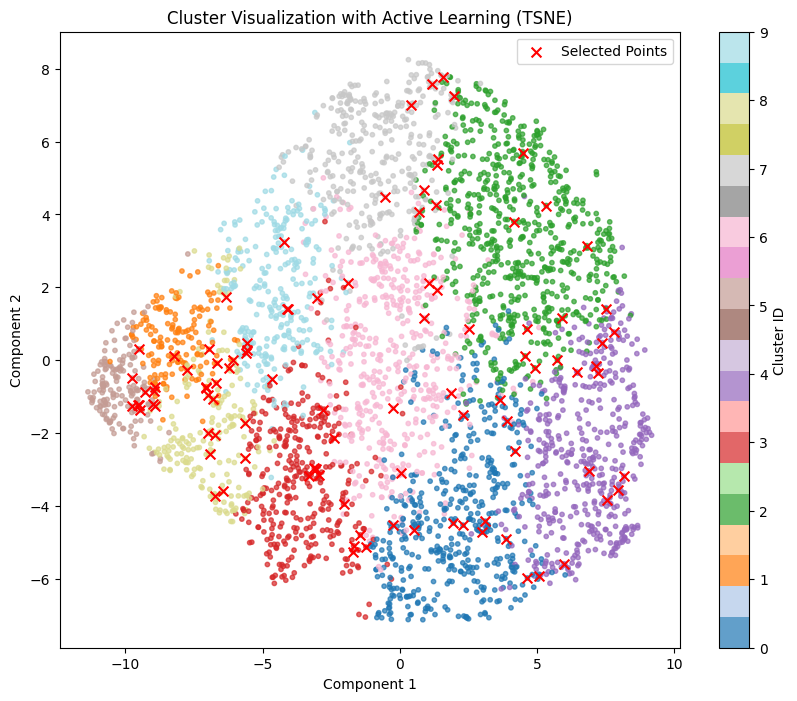

Selected 100 samples for labeling.


 14%|█▍        | 14/100 [00:01<00:10,  8.44it/s]

Epoch 10, Accuracy: 11.60%


 25%|██▌       | 25/100 [00:03<00:09,  8.04it/s]

Epoch 20, Accuracy: 16.10%


 36%|███▌      | 36/100 [00:04<00:07,  8.24it/s]

Epoch 30, Accuracy: 19.68%


 44%|████▍     | 44/100 [00:05<00:07,  7.65it/s]

Epoch 40, Accuracy: 21.34%


 55%|█████▌    | 55/100 [00:07<00:05,  8.04it/s]

Epoch 50, Accuracy: 22.28%


 66%|██████▌   | 66/100 [00:08<00:04,  8.20it/s]

Epoch 60, Accuracy: 23.12%


 73%|███████▎  | 73/100 [00:09<00:03,  7.15it/s]

Epoch 70, Accuracy: 23.02%


 84%|████████▍ | 84/100 [00:11<00:02,  7.87it/s]

Epoch 80, Accuracy: 23.18%


 95%|█████████▌| 95/100 [00:12<00:00,  8.15it/s]

Epoch 90, Accuracy: 22.90%


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 100, Accuracy: 23.26%


Extracting features: 100%|██████████| 56/56 [00:00<00:00, 59.25it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.7538932432946275


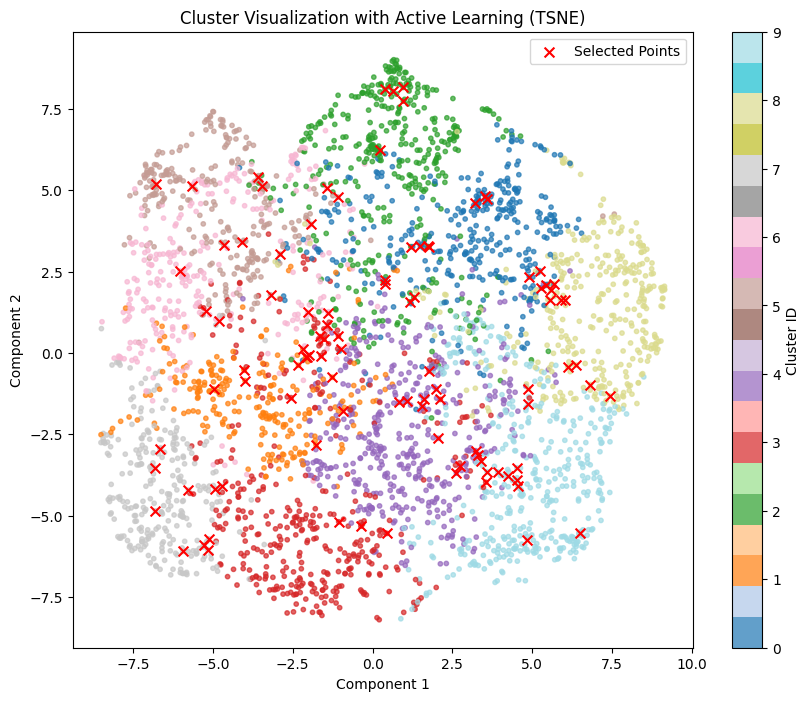

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:24,  3.63it/s]

Epoch 10, Accuracy: 23.32%


 21%|██        | 21/100 [00:04<00:23,  3.38it/s]

Epoch 20, Accuracy: 27.96%


 31%|███       | 31/100 [00:06<00:18,  3.67it/s]

Epoch 30, Accuracy: 29.40%


 41%|████      | 41/100 [00:07<00:15,  3.72it/s]

Epoch 40, Accuracy: 29.88%


 51%|█████     | 51/100 [00:09<00:13,  3.75it/s]

Epoch 50, Accuracy: 29.52%


 61%|██████    | 61/100 [00:11<00:10,  3.71it/s]

Epoch 60, Accuracy: 29.66%


 71%|███████   | 71/100 [00:13<00:07,  3.73it/s]

Epoch 70, Accuracy: 29.52%


 81%|████████  | 81/100 [00:15<00:05,  3.74it/s]

Epoch 80, Accuracy: 29.64%


 91%|█████████ | 91/100 [00:17<00:02,  3.59it/s]

Epoch 90, Accuracy: 29.72%


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 100, Accuracy: 29.64%


Extracting features: 100%|██████████| 54/54 [00:00<00:00, 60.01it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.688871700616847


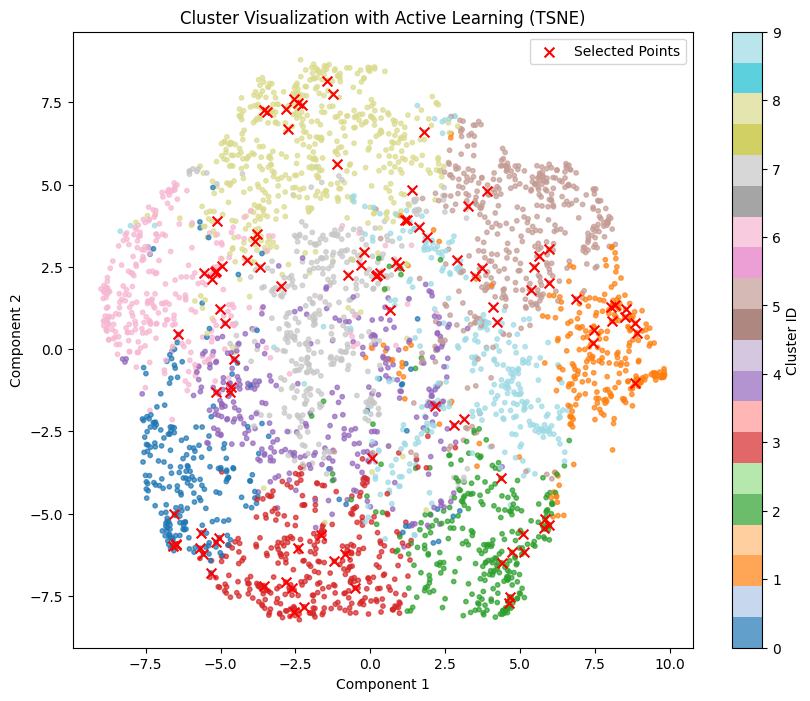

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:31,  2.80it/s]

Epoch 10, Accuracy: 30.40%


 21%|██        | 21/100 [00:05<00:28,  2.76it/s]

Epoch 20, Accuracy: 31.36%


 31%|███       | 31/100 [00:07<00:24,  2.82it/s]

Epoch 30, Accuracy: 31.56%


 41%|████      | 41/100 [00:09<00:23,  2.52it/s]

Epoch 40, Accuracy: 31.76%


 51%|█████     | 51/100 [00:12<00:18,  2.69it/s]

Epoch 50, Accuracy: 31.84%


 61%|██████    | 61/100 [00:14<00:13,  2.79it/s]

Epoch 60, Accuracy: 31.78%


 71%|███████   | 71/100 [00:17<00:10,  2.75it/s]

Epoch 70, Accuracy: 31.98%


 81%|████████  | 81/100 [00:19<00:06,  2.74it/s]

Epoch 80, Accuracy: 31.92%


 91%|█████████ | 91/100 [00:22<00:03,  2.75it/s]

Epoch 90, Accuracy: 32.00%


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Epoch 100, Accuracy: 32.00%


Extracting features: 100%|██████████| 53/53 [00:00<00:00, 56.35it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.6716772681512377


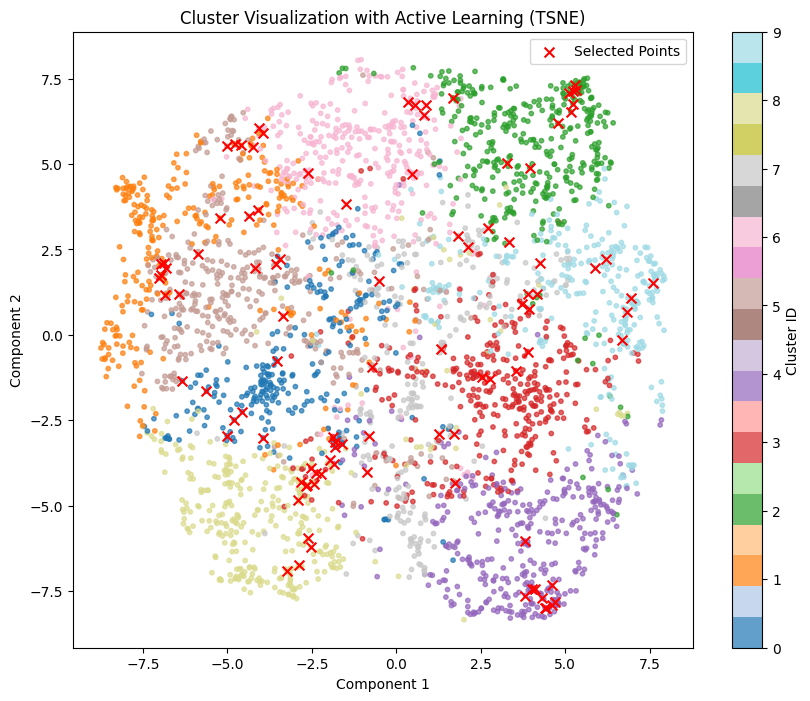

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:34,  2.61it/s]

Epoch 10, Accuracy: 35.96%


 21%|██        | 21/100 [00:05<00:31,  2.49it/s]

Epoch 20, Accuracy: 35.74%


 31%|███       | 31/100 [00:08<00:27,  2.55it/s]

Epoch 30, Accuracy: 36.34%


 41%|████      | 41/100 [00:10<00:23,  2.55it/s]

Epoch 40, Accuracy: 36.30%


 51%|█████     | 51/100 [00:13<00:20,  2.39it/s]

Epoch 50, Accuracy: 36.54%


 61%|██████    | 61/100 [00:16<00:15,  2.50it/s]

Epoch 60, Accuracy: 36.64%


 71%|███████   | 71/100 [00:19<00:11,  2.52it/s]

Epoch 70, Accuracy: 36.38%


 81%|████████  | 81/100 [00:21<00:07,  2.48it/s]

Epoch 80, Accuracy: 36.44%


 91%|█████████ | 91/100 [00:24<00:03,  2.43it/s]

Epoch 90, Accuracy: 36.72%


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Epoch 100, Accuracy: 36.66%
400


 10%|█         | 10/100 [00:01<00:10,  8.84it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.34it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.00it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:07,  7.80it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.30it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.78it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:09<00:03,  7.67it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  7.92it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.24it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


Epoch 100, Accuracy: 8.68%
100


 15%|█▌        | 15/100 [00:01<00:10,  8.07it/s]

Epoch 10, Accuracy: 14.48%


 23%|██▎       | 23/100 [00:03<00:12,  6.18it/s]

Epoch 20, Accuracy: 15.40%


 34%|███▍      | 34/100 [00:04<00:08,  7.40it/s]

Epoch 30, Accuracy: 19.30%


 45%|████▌     | 45/100 [00:05<00:07,  7.74it/s]

Epoch 40, Accuracy: 22.04%


 56%|█████▌    | 56/100 [00:07<00:05,  7.88it/s]

Epoch 50, Accuracy: 22.80%


 64%|██████▍   | 64/100 [00:08<00:04,  7.54it/s]

Epoch 60, Accuracy: 22.98%


 75%|███████▌  | 75/100 [00:09<00:03,  8.00it/s]

Epoch 70, Accuracy: 23.02%


 86%|████████▌ | 86/100 [00:11<00:01,  7.94it/s]

Epoch 80, Accuracy: 23.04%


 94%|█████████▍| 94/100 [00:12<00:00,  7.24it/s]

Epoch 90, Accuracy: 23.14%


100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 100, Accuracy: 23.38%
200


 11%|█         | 11/100 [00:01<00:23,  3.73it/s]

Epoch 10, Accuracy: 24.30%


 21%|██        | 21/100 [00:03<00:21,  3.67it/s]

Epoch 20, Accuracy: 28.60%


 31%|███       | 31/100 [00:05<00:19,  3.62it/s]

Epoch 30, Accuracy: 29.68%


 41%|████      | 41/100 [00:07<00:16,  3.51it/s]

Epoch 40, Accuracy: 29.84%


 51%|█████     | 51/100 [00:09<00:13,  3.58it/s]

Epoch 50, Accuracy: 29.98%


 61%|██████    | 61/100 [00:11<00:10,  3.64it/s]

Epoch 60, Accuracy: 30.00%


 71%|███████   | 71/100 [00:13<00:08,  3.61it/s]

Epoch 70, Accuracy: 30.10%


 81%|████████  | 81/100 [00:15<00:05,  3.68it/s]

Epoch 80, Accuracy: 30.26%


 91%|█████████ | 91/100 [00:17<00:02,  3.66it/s]

Epoch 90, Accuracy: 29.98%


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Epoch 100, Accuracy: 30.22%
400


 11%|█         | 11/100 [00:02<00:34,  2.55it/s]

Epoch 10, Accuracy: 36.12%


 21%|██        | 21/100 [00:05<00:32,  2.44it/s]

Epoch 20, Accuracy: 38.98%


 31%|███       | 31/100 [00:08<00:26,  2.56it/s]

Epoch 30, Accuracy: 39.22%


 41%|████      | 41/100 [00:10<00:22,  2.58it/s]

Epoch 40, Accuracy: 39.22%


 51%|█████     | 51/100 [00:13<00:19,  2.52it/s]

Epoch 50, Accuracy: 39.24%


 61%|██████    | 61/100 [00:16<00:15,  2.56it/s]

Epoch 60, Accuracy: 39.36%


 71%|███████   | 71/100 [00:18<00:11,  2.55it/s]

Epoch 70, Accuracy: 39.66%


 81%|████████  | 81/100 [00:21<00:07,  2.47it/s]

Epoch 80, Accuracy: 39.30%


 91%|█████████ | 91/100 [00:24<00:03,  2.56it/s]

Epoch 90, Accuracy: 39.28%


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]

Epoch 100, Accuracy: 39.24%
800


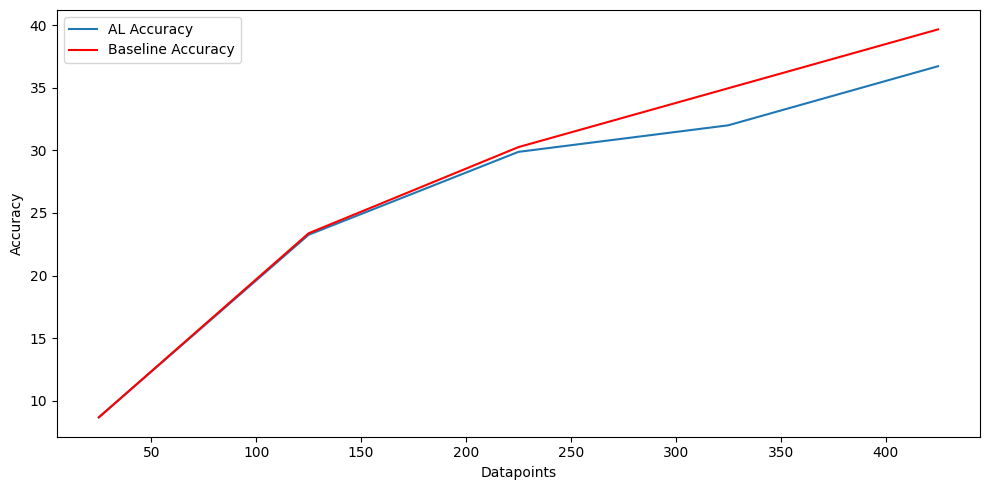

In [24]:
datapoints1,accuracies1,baseline_datapoint_list1,baseline_accuracy_list1=run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations,cluster=label_iteration_with_clustering)


 10%|█         | 10/100 [00:01<00:12,  7.20it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.27it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.29it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.18it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  8.01it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.75it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  8.07it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:09<00:02,  8.21it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.17it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 50/50 [00:00<00:00, 53.16it/s]


Cluster distribution: {np.int64(-1): np.int64(72), np.int64(0): np.int64(3117)}
Found 72 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


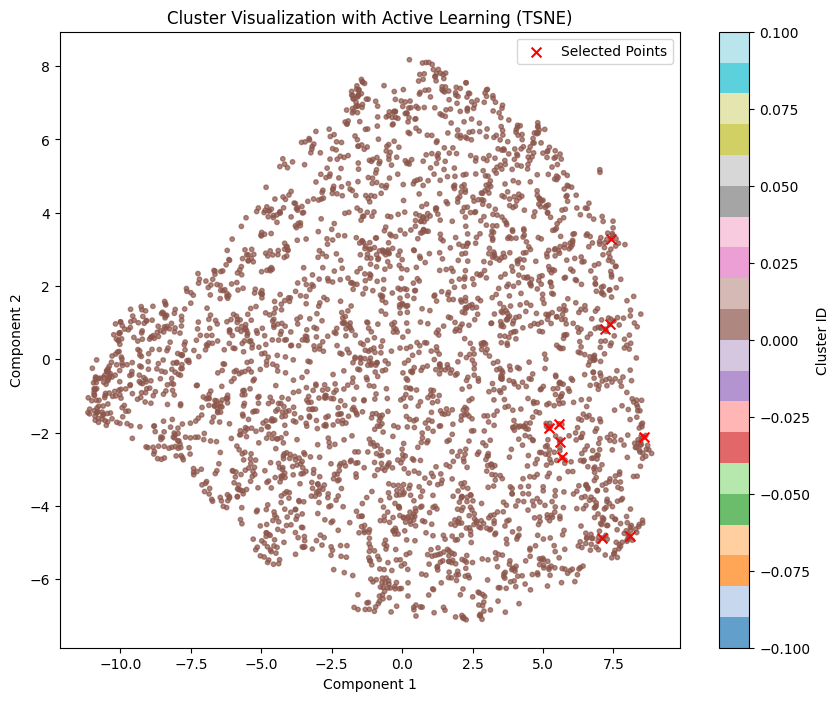

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 10%|█         | 10/100 [00:01<00:12,  7.01it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.08it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.16it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.13it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.95it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.69it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  7.76it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  8.14it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.21it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 50/50 [00:01<00:00, 49.23it/s]


Cluster distribution: {np.int64(-1): np.int64(72), np.int64(0): np.int64(3107)}
Found 72 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


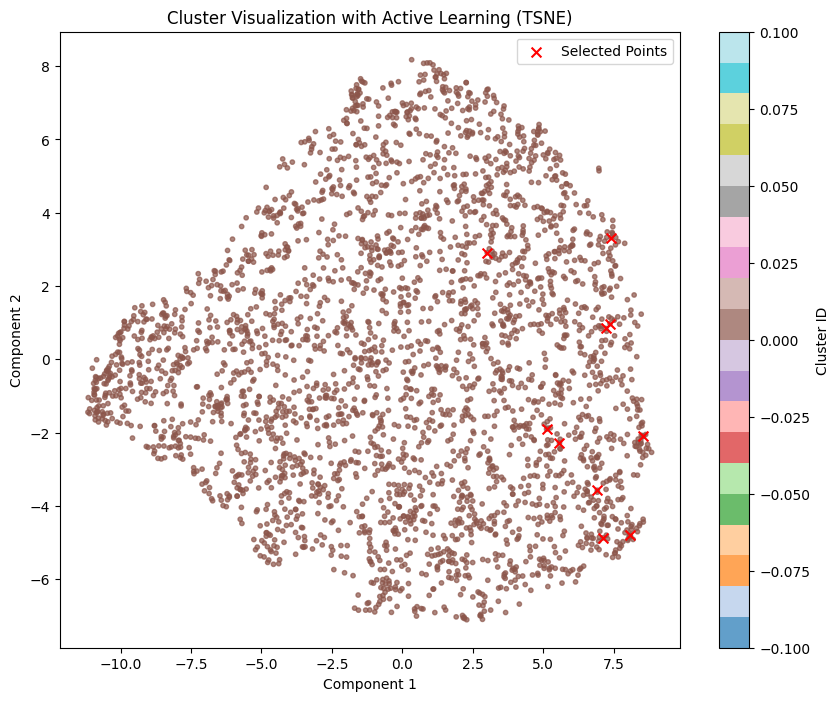

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 10%|█         | 10/100 [00:01<00:12,  7.25it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.16it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.23it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.12it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.65it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.74it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  8.09it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:09<00:02,  8.21it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.06it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 50/50 [00:00<00:00, 56.42it/s]


Cluster distribution: {np.int64(-1): np.int64(72), np.int64(0): np.int64(3097)}
Found 72 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


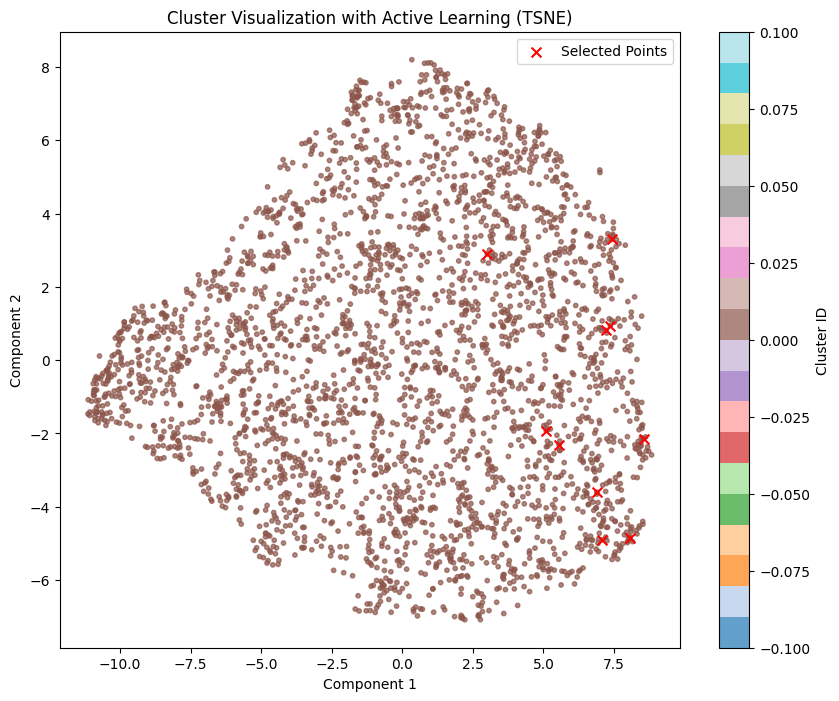

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 10%|█         | 10/100 [00:01<00:13,  6.47it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:10,  7.80it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.05it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:07,  8.04it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.61it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:04,  8.08it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  8.30it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:09<00:02,  8.22it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  7.95it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 50/50 [00:01<00:00, 48.75it/s]


Cluster distribution: {np.int64(-1): np.int64(72), np.int64(0): np.int64(3087)}
Found 72 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


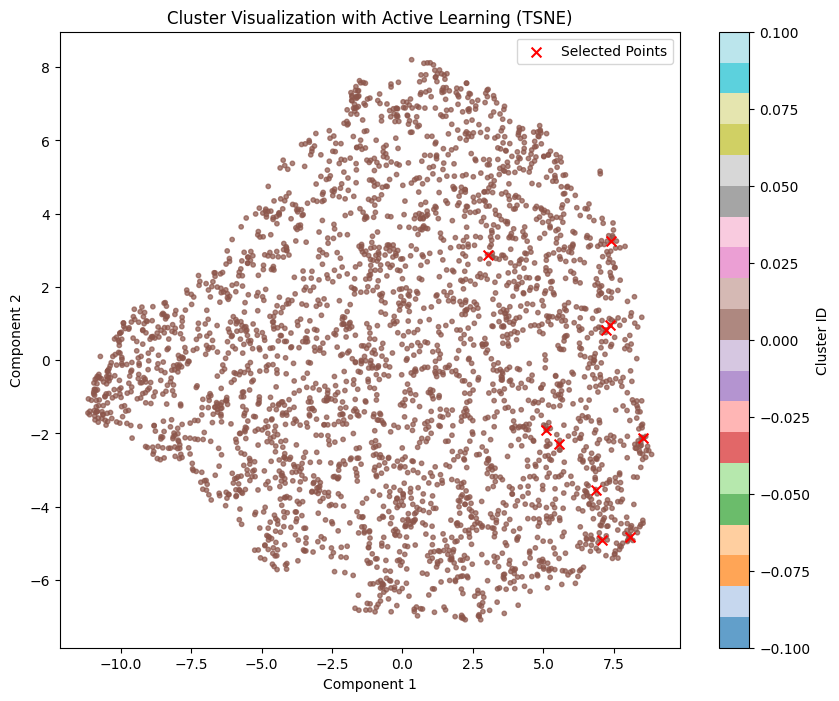

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 14%|█▍        | 14/100 [00:01<00:09,  9.07it/s]

Epoch 10, Accuracy: 14.00%


 26%|██▌       | 26/100 [00:02<00:08,  8.95it/s]

Epoch 20, Accuracy: 15.36%


 33%|███▎      | 33/100 [00:04<00:09,  7.34it/s]

Epoch 30, Accuracy: 16.76%


 43%|████▎     | 43/100 [00:05<00:07,  7.22it/s]

Epoch 40, Accuracy: 17.88%


 54%|█████▍    | 54/100 [00:07<00:05,  7.73it/s]

Epoch 50, Accuracy: 18.32%


 65%|██████▌   | 65/100 [00:08<00:04,  7.89it/s]

Epoch 60, Accuracy: 18.22%


 76%|███████▌  | 76/100 [00:10<00:03,  7.78it/s]

Epoch 70, Accuracy: 18.24%


 83%|████████▎ | 83/100 [00:11<00:02,  6.84it/s]

Epoch 80, Accuracy: 18.26%


 93%|█████████▎| 93/100 [00:12<00:00,  7.22it/s]

Epoch 90, Accuracy: 18.20%


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 100, Accuracy: 18.24%
40


 10%|█         | 10/100 [00:01<00:10,  8.71it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.52it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.41it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  7.90it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.48it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.98it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  8.11it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  7.79it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.07it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 100, Accuracy: 8.68%
10


 10%|█         | 10/100 [00:01<00:11,  7.74it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:11,  7.11it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  7.92it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:07,  8.13it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  8.18it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:04,  8.09it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  7.66it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  8.08it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.24it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Epoch 100, Accuracy: 8.68%
20


 10%|█         | 10/100 [00:01<00:10,  8.77it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.50it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:08,  8.32it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:07,  8.37it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:05<00:06,  8.30it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:04,  8.08it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  7.80it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:09<00:02,  7.93it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  8.12it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 100, Accuracy: 8.68%
40


 16%|█▌        | 16/100 [00:01<00:08,  9.68it/s]

Epoch 10, Accuracy: 12.66%


 23%|██▎       | 23/100 [00:02<00:10,  7.52it/s]

Epoch 20, Accuracy: 14.12%


 34%|███▍      | 34/100 [00:04<00:08,  7.60it/s]

Epoch 30, Accuracy: 16.66%


 44%|████▍     | 44/100 [00:05<00:08,  6.76it/s]

Epoch 40, Accuracy: 18.42%


 54%|█████▍    | 54/100 [00:07<00:06,  6.94it/s]

Epoch 50, Accuracy: 19.16%


 65%|██████▌   | 65/100 [00:08<00:04,  7.61it/s]

Epoch 60, Accuracy: 19.38%


 76%|███████▌  | 76/100 [00:10<00:02,  8.08it/s]

Epoch 70, Accuracy: 19.76%


 83%|████████▎ | 83/100 [00:11<00:02,  7.02it/s]

Epoch 80, Accuracy: 19.76%


 94%|█████████▍| 94/100 [00:12<00:00,  7.57it/s]

Epoch 90, Accuracy: 19.76%


100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 100, Accuracy: 19.82%
80


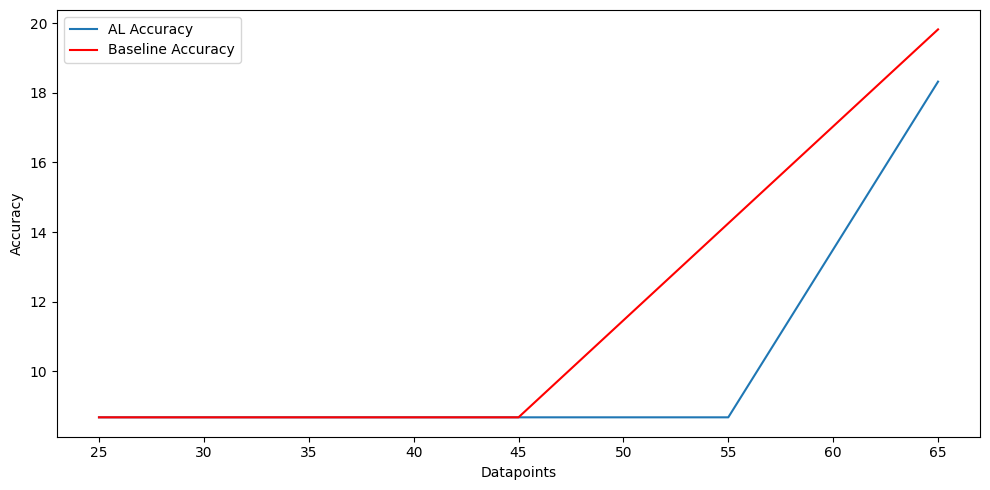

In [28]:
datapoints2,accuracies2,baseline_datapoint_list2,baseline_accuracy_list2=run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations,cluster=label_iteration_with_dbscan)


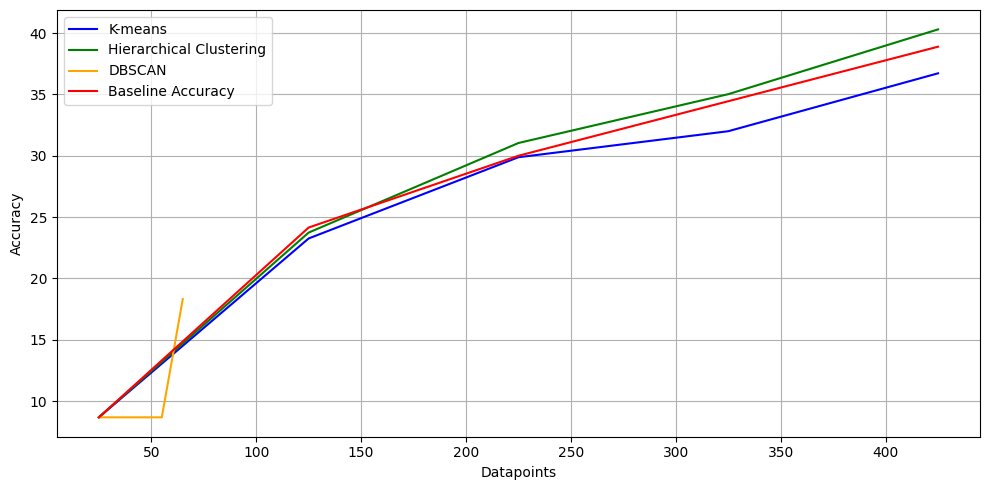

In [35]:
# Ensure the lists are numpy arrays
baseline_datapoint_list1 = np.array(baseline_datapoint_list1)
baseline_datapoint_list = np.array(baseline_datapoint_list)
baseline_datapoint_list2 = np.array(baseline_datapoint_list2)

baseline_accuracy_list1 = np.array(baseline_accuracy_list1)
baseline_accuracy_list = np.array(baseline_accuracy_list)
baseline_accuracy_list3 = np.array(baseline_accuracy_list2)

# Compute the element-wise mean
mean_baseline_datapoints = (baseline_datapoint_list1 + baseline_datapoint_list) / 2
mean_baseline_accuracy = (baseline_accuracy_list1 + baseline_accuracy_list) / 2

plt.figure(figsize=(10, 5))
plt.plot(datapoints1, accuracies1, label='K-means',color='blue')
plt.plot(datapoints, accuracies, label='Hierarchical Clustering',color='green')
plt.plot(datapoints2, accuracies2, label='DBSCAN',color='orange')
plt.plot(mean_baseline_datapoints,mean_baseline_accuracy, label='Baseline Accuracy', color='red')
plt.grid()
plt.xlabel('Datapoints')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
#plt.savefig('figs/accuracy.png')
plt.show()

 10%|█         | 10/100 [00:02<00:25,  3.46it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:05<00:22,  3.59it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:08<00:20,  3.49it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:11<00:17,  3.44it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:14<00:14,  3.47it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:17<00:11,  3.51it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:19<00:08,  3.57it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:22<00:05,  3.53it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:26<00:02,  3.36it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 57/57 [00:02<00:00, 20.39it/s]


Cluster distribution: {np.int64(-1): np.int64(204), np.int64(0): np.int64(3430)}
Found 204 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


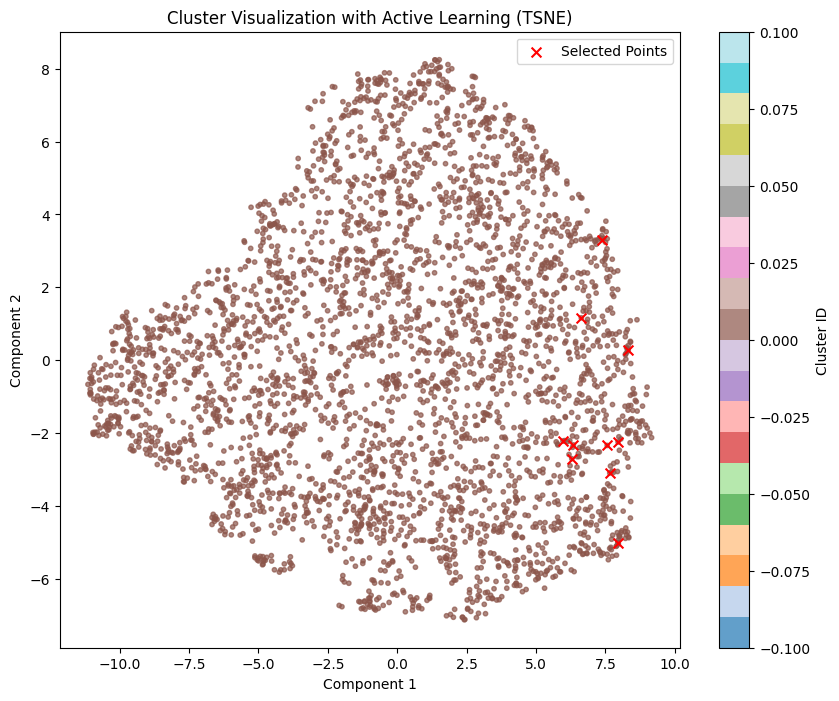

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 10%|█         | 10/100 [00:03<00:30,  2.92it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:06<00:24,  3.30it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:09<00:20,  3.39it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:11<00:17,  3.40it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:14<00:14,  3.46it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:17<00:11,  3.48it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:20<00:08,  3.56it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:23<00:05,  3.51it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:25<00:02,  3.61it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 57/57 [00:02<00:00, 22.65it/s]


Cluster distribution: {np.int64(-1): np.int64(204), np.int64(0): np.int64(3420)}
Found 204 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


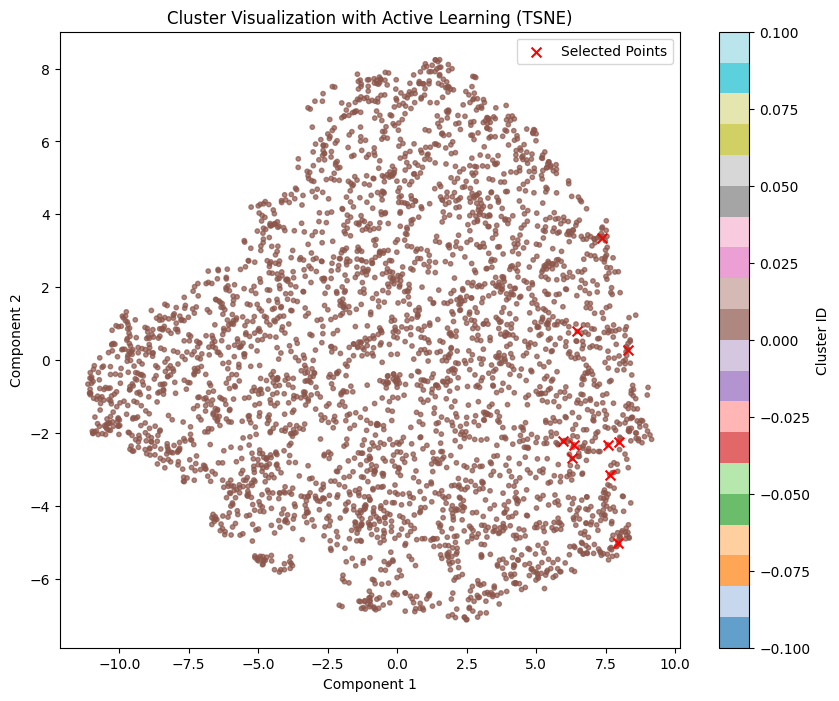

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 10%|█         | 10/100 [00:02<00:23,  3.86it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:05<00:21,  3.67it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:08<00:19,  3.60it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:11<00:16,  3.55it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:13<00:13,  3.57it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:16<00:11,  3.58it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:19<00:08,  3.61it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:22<00:05,  3.57it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:25<00:02,  3.51it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 57/57 [00:02<00:00, 19.52it/s]


Cluster distribution: {np.int64(-1): np.int64(204), np.int64(0): np.int64(3410)}
Found 204 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


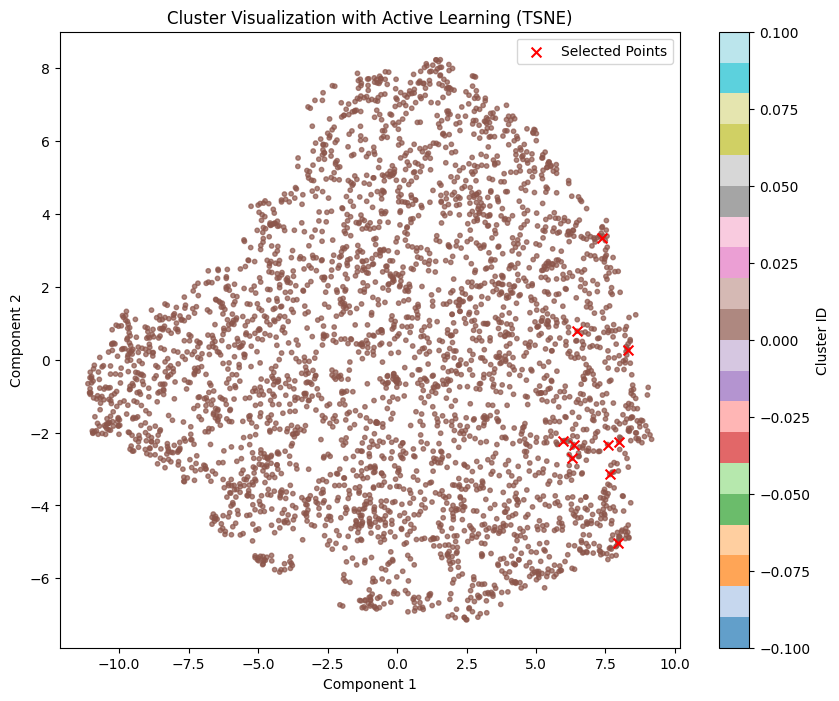

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 10%|█         | 10/100 [00:02<00:26,  3.45it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:05<00:23,  3.39it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:08<00:20,  3.42it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:11<00:17,  3.47it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:14<00:13,  3.58it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:17<00:11,  3.48it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:20<00:08,  3.50it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:22<00:05,  3.53it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:25<00:02,  3.60it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 57/57 [00:02<00:00, 23.08it/s]


Cluster distribution: {np.int64(-1): np.int64(203), np.int64(0): np.int64(3401)}
Found 203 noise points. Excluding them from selection.
-----hello-----
-----hi-----
num_clusters : 1


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


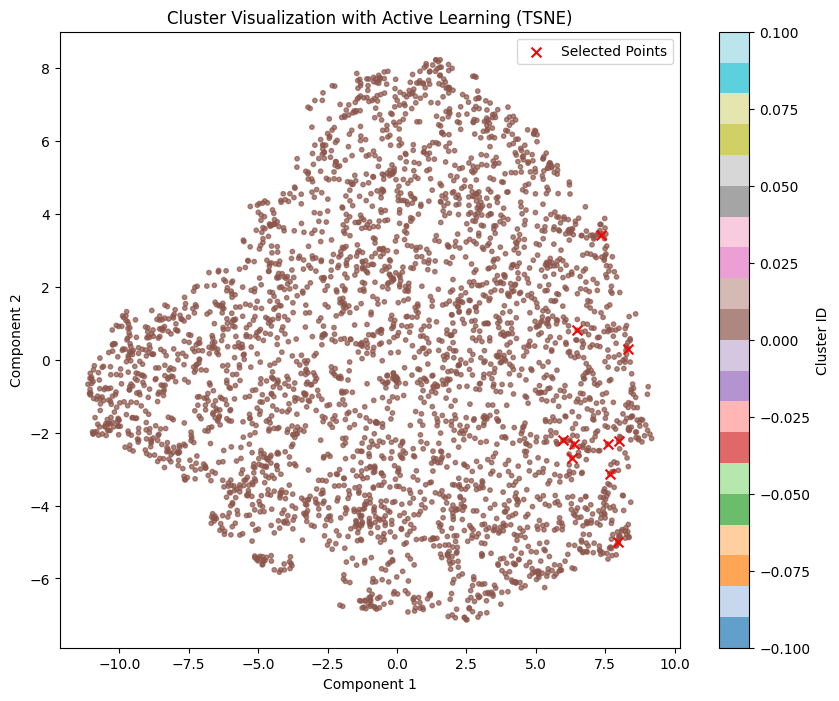

Davies-Bouldin Index: Only one cluster
Selected 10 samples for labeling.


 13%|█▎        | 13/100 [00:03<00:32,  2.71it/s]

Epoch 10, Accuracy: 16.76%


 21%|██        | 21/100 [00:06<00:42,  1.85it/s]

Epoch 20, Accuracy: 16.96%


 33%|███▎      | 33/100 [00:10<00:27,  2.44it/s]

Epoch 30, Accuracy: 18.88%


 43%|████▎     | 43/100 [00:13<00:24,  2.33it/s]

Epoch 40, Accuracy: 20.76%


 53%|█████▎    | 53/100 [00:17<00:18,  2.50it/s]

Epoch 50, Accuracy: 21.50%


 61%|██████    | 61/100 [00:20<00:22,  1.75it/s]

Epoch 60, Accuracy: 21.96%


 71%|███████   | 71/100 [00:23<00:16,  1.80it/s]

Epoch 70, Accuracy: 22.08%


 81%|████████  | 81/100 [00:27<00:10,  1.75it/s]

Epoch 80, Accuracy: 22.14%


 91%|█████████ | 91/100 [00:30<00:05,  1.75it/s]

Epoch 90, Accuracy: 22.16%


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


Epoch 100, Accuracy: 22.14%
40


 10%|█         | 10/100 [00:02<00:24,  3.65it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:05<00:22,  3.58it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:08<00:19,  3.56it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:11<00:16,  3.62it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:13<00:13,  3.62it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:16<00:10,  3.68it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:19<00:08,  3.48it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:22<00:05,  3.54it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:25<00:02,  3.55it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 100, Accuracy: 8.68%
10


 10%|█         | 10/100 [00:02<00:26,  3.44it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:05<00:23,  3.42it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:08<00:20,  3.44it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:11<00:17,  3.46it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:14<00:14,  3.48it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:17<00:11,  3.45it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:20<00:08,  3.56it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:23<00:05,  3.47it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:25<00:02,  3.50it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


Epoch 100, Accuracy: 8.68%
20


 10%|█         | 10/100 [00:02<00:22,  3.99it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:05<00:21,  3.78it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:07<00:18,  3.82it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:10<00:15,  3.88it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:12<00:12,  3.93it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:15<00:10,  3.80it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:18<00:07,  3.82it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:21<00:05,  3.74it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:23<00:02,  3.75it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Epoch 100, Accuracy: 8.68%
40


 12%|█▏        | 12/100 [00:03<00:34,  2.58it/s]

Epoch 10, Accuracy: 13.82%


 22%|██▏       | 22/100 [00:06<00:31,  2.48it/s]

Epoch 20, Accuracy: 15.12%


 32%|███▏      | 32/100 [00:10<00:26,  2.55it/s]

Epoch 30, Accuracy: 18.08%


 42%|████▏     | 42/100 [00:13<00:21,  2.75it/s]

Epoch 40, Accuracy: 19.14%


 52%|█████▏    | 52/100 [00:16<00:19,  2.41it/s]

Epoch 50, Accuracy: 19.34%


 62%|██████▏   | 62/100 [00:19<00:14,  2.58it/s]

Epoch 60, Accuracy: 19.70%


 72%|███████▏  | 72/100 [00:23<00:12,  2.22it/s]

Epoch 70, Accuracy: 19.68%


 82%|████████▏ | 82/100 [00:26<00:07,  2.47it/s]

Epoch 80, Accuracy: 19.80%


 92%|█████████▏| 92/100 [00:29<00:02,  2.69it/s]

Epoch 90, Accuracy: 19.86%


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]

Epoch 100, Accuracy: 19.88%
80


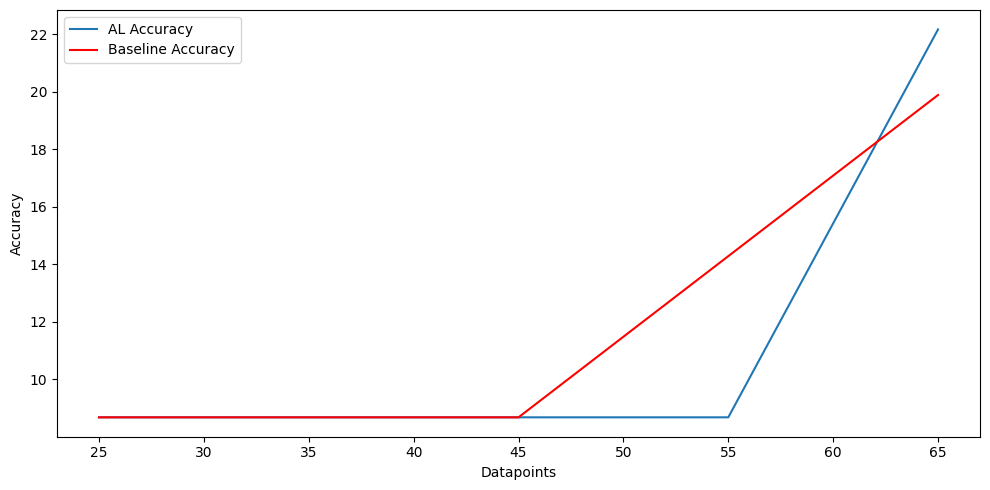

In [39]:

datapoints1,accuracies1,baseline_datapoint_list1,baseline_accuracy_list1=run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations,cluster=label_iteration_with_dbscan)